# Intoduction:

In this project, we will be developing a prototype of a machine learning model for Zyfra, a company that specializes in providing efficiency solutions for heavy industry. The goal of this project is to predict the amount of gold recovered from gold ore, using data on extraction and purification processes. By optimizing production and eliminating unprofitable parameters, this model will help improve efficiency in the gold extraction process.

To achieve this, we will need to prepare the data, perform data analysis, and develop and train a machine learning model. The documentation from pandas, matplotlib, and sklearn will be utilized throughout the project.

By understanding and analyzing the stages of the gold extraction process, such as flotation and purification, and considering parameters such as rougher feed, reagent additions, and various technological and stage-specific factors, we aim to create a robust machine learning model that accurately predicts the amount of gold recovered from gold ore.



# Data description

-  Technological process:

- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
 - Xanthate — promoter or flotation activator;
 - Sulphate — sodium sulphide for this particular process;
 - Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate


-  Parameters of stages

- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate
- Feature naming
- Here's how you name the features:


-  Possible values for [stage]:

- rougher — flotation
- primary_cleaner — primary purification
- secondary_cleaner — secondary purification
- final — final characteristics


-  Possible values for [parameter_type]:

- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics



# Data Processing:

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import RandomizedSearchCV


In [92]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv') 
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [93]:
print(train.shape)
print(test.shape)
print(full.shape)

(16860, 87)
(5856, 53)
(22716, 87)


In [94]:
print(f"Duplicated values in the train dataset: {train.duplicated().sum()} ")
print(f"Duplicated values in the test dataset: {test.duplicated().sum()} ")
print(f"Duplicated values in the full dataset: {full.duplicated().sum()} ")

Duplicated values in the train dataset: 0 
Duplicated values in the test dataset: 0 
Duplicated values in the full dataset: 0 


In [95]:
print(f"Missing values in the train dataset:\n{train.isna().sum()}")

Missing values in the train dataset:
date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64


In [96]:
print(f"Missing values in the test dataset:\n{test.isna().sum()}")

Missing values in the test dataset:
date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.

In [97]:
print(f"Missing values in the full dataset:\n{full.isna().sum()}")

Missing values in the full dataset:
date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64


In [98]:
 '''Recovery is calculated using the following equation: ((C * (F-T)) / (F * (C-T))) * 100. 
 C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
 F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
 T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
'''




def calc_recovery(data, calc_type="rougher"):
   
    
    C = data[f'{calc_type}.output.concentrate_au']
    T = data[f'{calc_type}.output.tail_au']
    F = data['rougher.input.feed_au'] if calc_type == "rougher" else data['rougher.output.concentrate_au']
    
    recovery = ((C * (F-T)) / (F * (C-T))) * 100
    
    print(f"Calculated Recovery for '{calc_type}' \n{recovery}")
    
    # Add recovery to dataframe
    data[f'{calc_type}.calculated.recovery'] = recovery
    
    # Replace infinity values with NaN
    data[f'{calc_type}.calculated.recovery'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return data, recovery

In [99]:
#Rougher recovery for gold_train
train, predicted_recovery_values = calc_recovery(train.dropna(subset=['rougher.output.recovery']), calc_type="rougher")

#values for actual recovery
actual_recovery_values = train['rougher.output.recovery']

print(f"Actual Recovery for 'rougher':\n{actual_recovery_values}")

Calculated Recovery for 'rougher' 
0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 14287, dtype: float64
Actual Recovery for 'rougher':
0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 14287, dtype: float64


/tmp/ipykernel_32/201892806.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{calc_type}.calculated.recovery'] = recovery
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [100]:
print(actual_recovery_values.isna().sum())
print(predicted_recovery_values.isna().sum())

0
0


In [101]:
valid_indices = ~predicted_recovery_values.isin([np.nan, np.inf, -np.inf])
actual_recovery_values = actual_recovery_values[valid_indices]
predicted_recovery_values = predicted_recovery_values[valid_indices]

#Calculate MAE between actual and calculated recovery values
mae = mean_absolute_error(actual_recovery_values, predicted_recovery_values)

print(f"Mean Absolute Error (MAE) between actual and calculated recovery values: {mae}")

Mean Absolute Error (MAE) between actual and calculated recovery values: 9.303415616264301e-15


In [102]:
# fill missing data using ffill on the test dataset
test.fillna(method='ffill', inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5856 non-null   float64
 2   primary_cleaner.input.depressant            5856 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 10  primary_clea

In [103]:
# fill missing data using ffill on the train dataset
train.fillna(method='ffill', inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14287 non-null  object 
 1   final.output.concentrate_ag                         14287 non-null  float64
 2   final.output.concentrate_pb                         14287 non-null  float64
 3   final.output.concentrate_sol                        14287 non-null  float64
 4   final.output.concentrate_au                         14287 non-null  float64
 5   final.output.recovery                               14287 non-null  float64
 6   final.output.tail_ag                                14287 non-null  float64
 7   final.output.tail_pb                                14287 non-null  float64
 8   final.output.tail_sol                               14287 non-null  float64


In [104]:
# fill missing data using ffill on the full dataset
full.fillna(method='ffill', inplace=True)
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22716 non-null  float64
 2   final.output.concentrate_pb                         22716 non-null  float64
 3   final.output.concentrate_sol                        22716 non-null  float64
 4   final.output.concentrate_au                         22716 non-null  float64
 5   final.output.recovery                               22716 non-null  float64
 6   final.output.tail_ag                                22716 non-null  float64
 7   final.output.tail_pb                                22716 non-null  float64
 8   final.output.tail_sol                               22716 non-null  float64


In [105]:
# missing columns
missing_columns = set(train.columns) - set(test.columns)

# Change the set to a list
missing_list = list(missing_columns)

display(missing_list)

['rougher.output.tail_pb',
 'final.output.recovery',
 'rougher.output.concentrate_ag',
 'final.output.concentrate_pb',
 'primary_cleaner.output.tail_ag',
 'final.output.tail_au',
 'rougher.output.recovery',
 'final.output.concentrate_ag',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.concentrate_pb',
 'final.output.tail_pb',
 'rougher.output.tail_ag',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'secondary_cleaner.output.tail_ag',
 'rougher.calculation.sulfate_to_au_concentrate',
 'primary_cleaner.output.concentrate_pb',
 'rougher.calculated.recovery',
 'secondary_cleaner.output.tail_au',
 'rougher.output.tail_au',
 'final.output.tail_ag',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.tail_pb',
 'final.output.concentrate_sol',
 'final.output.tail_sol',
 'final.output.concentrate_au',
 'rougher.output.concentrate_sol',
 'secondary_cleaner.output.tail_sol',
 'p

# Data Analysis

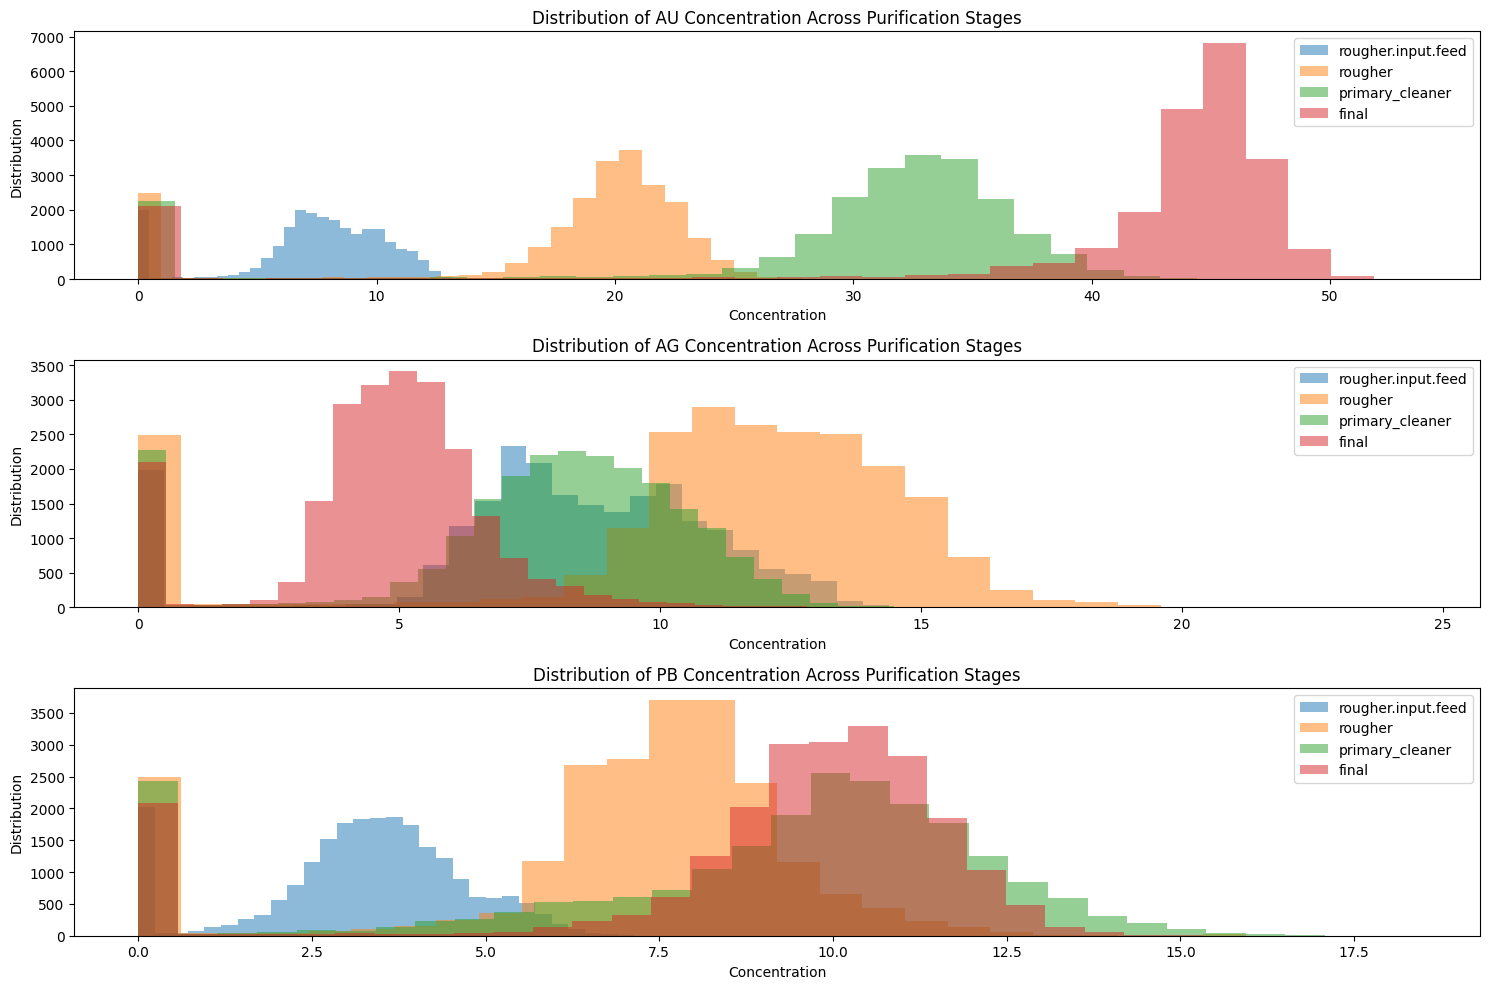

In [106]:
stages = ['rougher.input.feed', 'rougher', 'primary_cleaner', 'final']
metals = ['au', 'ag', 'pb']

# Plot histograms for each metal
plt.figure(figsize=(15, 10))

for i, metal in enumerate(metals, 1):
    plt.subplot(3, 1, i)
    for stage in stages:
        column_name = f'{stage}.output.concentrate_{metal}' if stage != 'rougher.input.feed' else f'{stage}_{metal}'
        plt.hist(full[column_name], bins=30, alpha=0.5, label=stage)
    plt.title(f'Distribution of {metal.upper()} Concentration Across Purification Stages')
    plt.xlabel('Concentration')
    plt.ylabel('Distribution')
    plt.legend()
    

plt.tight_layout()
plt.show()

The concentration of gold, silver, and lead decreases consistently throughout the purification process, with the final stage showing the lowest concentrations for each metal. This indicates successful purification and standardization of concentration distribution.

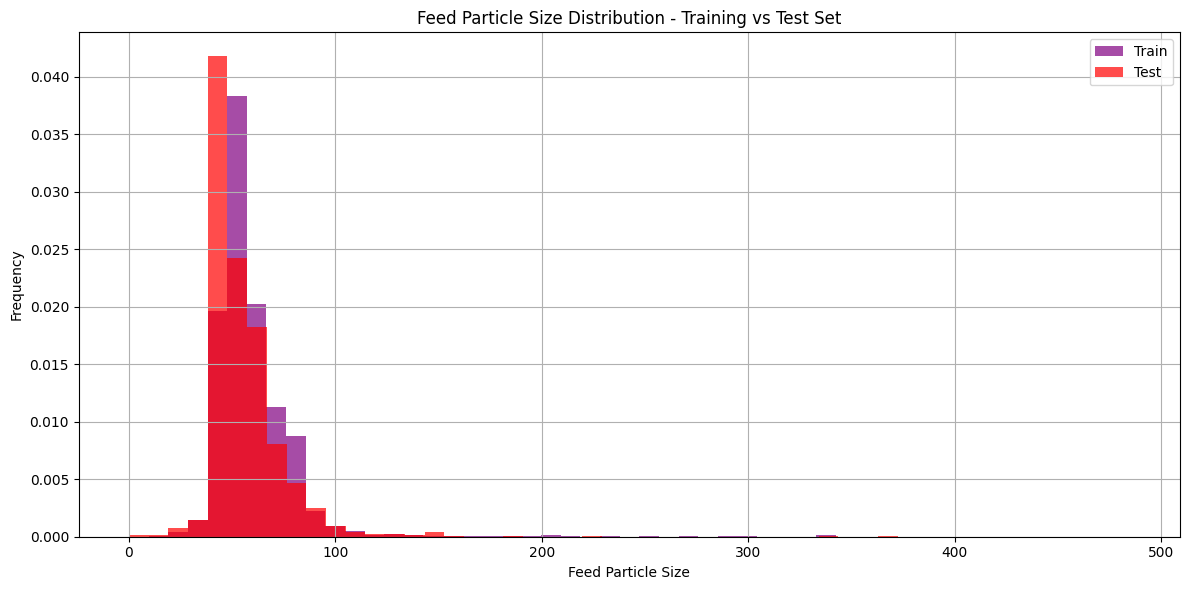

Training Set Feed Particle Size Summary:
count    14287.000000
mean        60.179089
std         22.985089
min          9.659576
25%         48.932377
50%         55.251872
75%         65.976914
max        484.967466
Name: rougher.input.feed_size, dtype: float64
Test Set Feed Particle Size Summary:
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


In [107]:

plt.figure(figsize=(12, 6))

# Overlay normalized histograms for training and test sets
plt.hist(train['rougher.input.feed_size'], bins=50, alpha=0.7, label='Train', color='purple',density=True)
plt.hist(test['rougher.input.feed_size'], bins=50, alpha=0.7, label='Test', color='red',density=True)

plt.title('Feed Particle Size Distribution - Training vs Test Set')
plt.xlabel('Feed Particle Size')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

train_summary = train['rougher.input.feed_size'].describe()
test_summary = test['rougher.input.feed_size'].describe()

print(f"Training Set Feed Particle Size Summary:\n{train_summary}")
print(f"Test Set Feed Particle Size Summary:\n{test_summary}")


The training set has a higher presence of smaller particle sizes compared to the test set, which shows a more gradual decrease in particle size. This discrepancy suggests a potential misalignment between the two sets that could affect model performance.

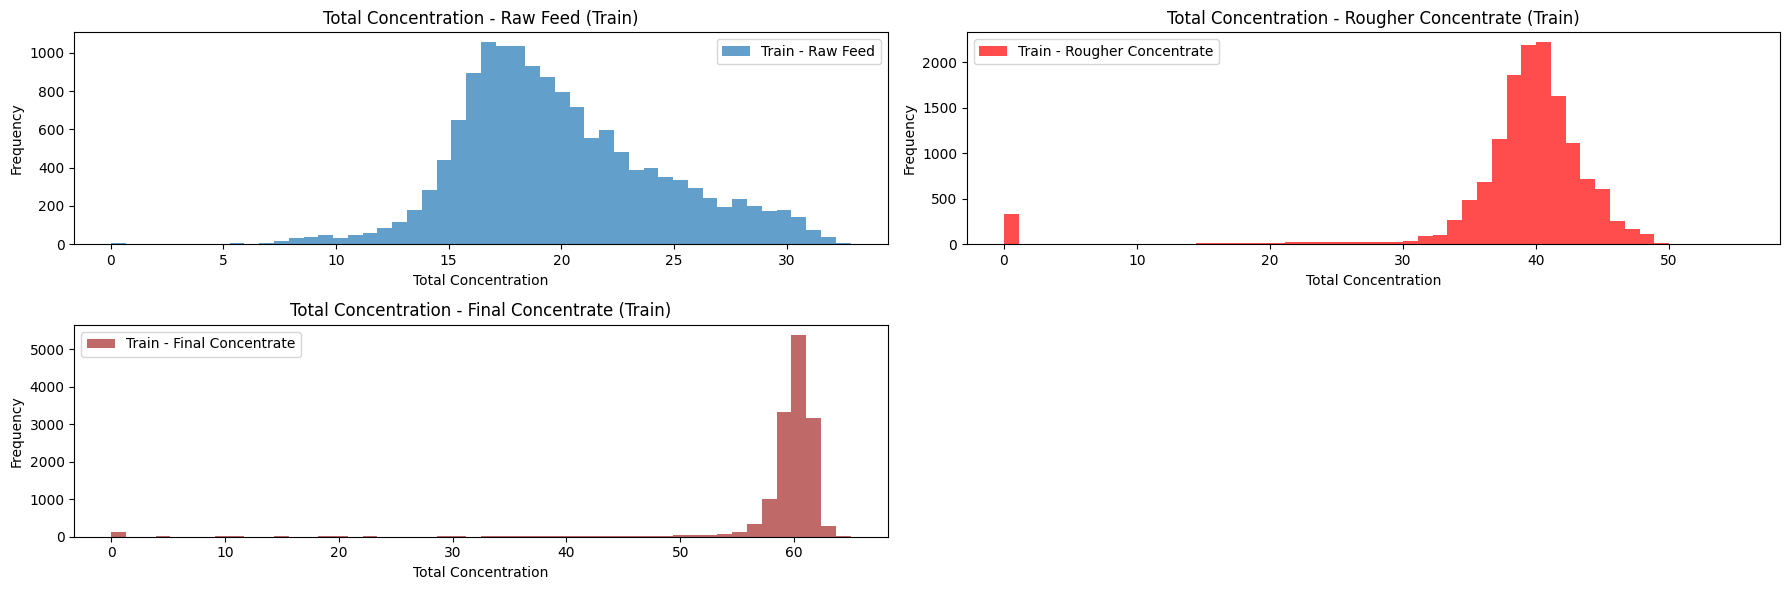

In [108]:
# Calculating total concentrations for training 
train['total_concentration_raw_feed'] = train[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
train['total_concentration_rougher'] = train[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
train['total_concentration_final'] = train[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

# Plotting the concentrations
plt.figure(figsize=(18, 6))

# Training set
plt.subplot(2, 2, 1)
plt.hist(train['total_concentration_raw_feed'], bins=50, alpha=0.7, label='Train - Raw Feed')
plt.title('Total Concentration - Raw Feed (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(train['total_concentration_rougher'], bins=50, alpha=0.7, label='Train - Rougher Concentrate', color='red')
plt.title('Total Concentration - Rougher Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(train['total_concentration_final'], bins=50, alpha=0.7, label='Train - Final Concentrate', color='brown')
plt.title('Total Concentration - Final Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

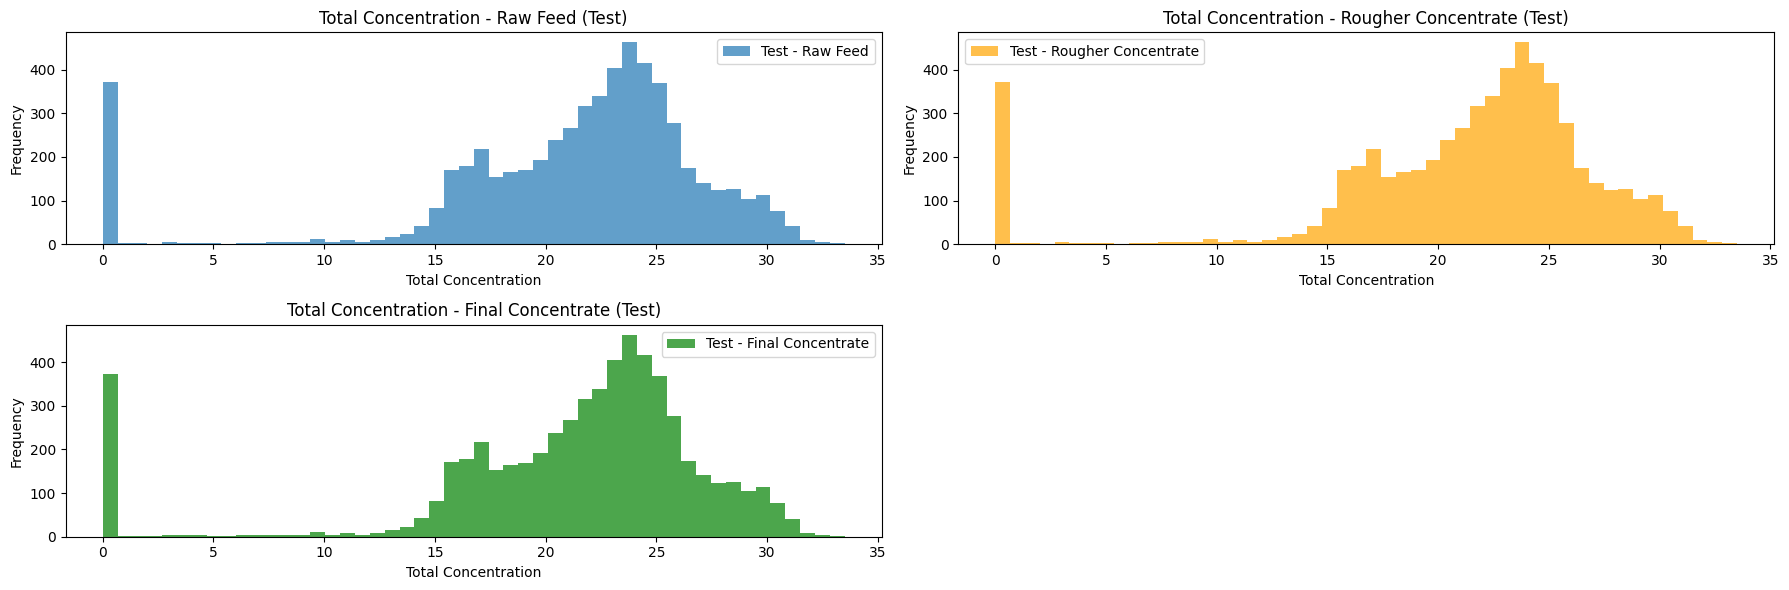

In [109]:
# Calculating concentrations for test set
test['total_concentration_raw_feed'] = test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
test['total_concentration_rougher'] = test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
test['total_concentration_final'] = test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)

# Plotting total concentrations
plt.figure(figsize=(18, 6))

# Test set
plt.subplot(2, 2, 1)
plt.hist(test['total_concentration_raw_feed'], bins=50, alpha=0.7, label='Test - Raw Feed')
plt.title('Total Concentration - Raw Feed (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(test['total_concentration_rougher'], bins=50, alpha=0.7, label='Test - Rougher Concentrate', color='orange')
plt.title('Total Concentration - Rougher Concentrate (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(test['total_concentration_final'], bins=50, alpha=0.7, label='Test - Final Concentrate', color='green')
plt.title('Total Concentration - Final Concentrate (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

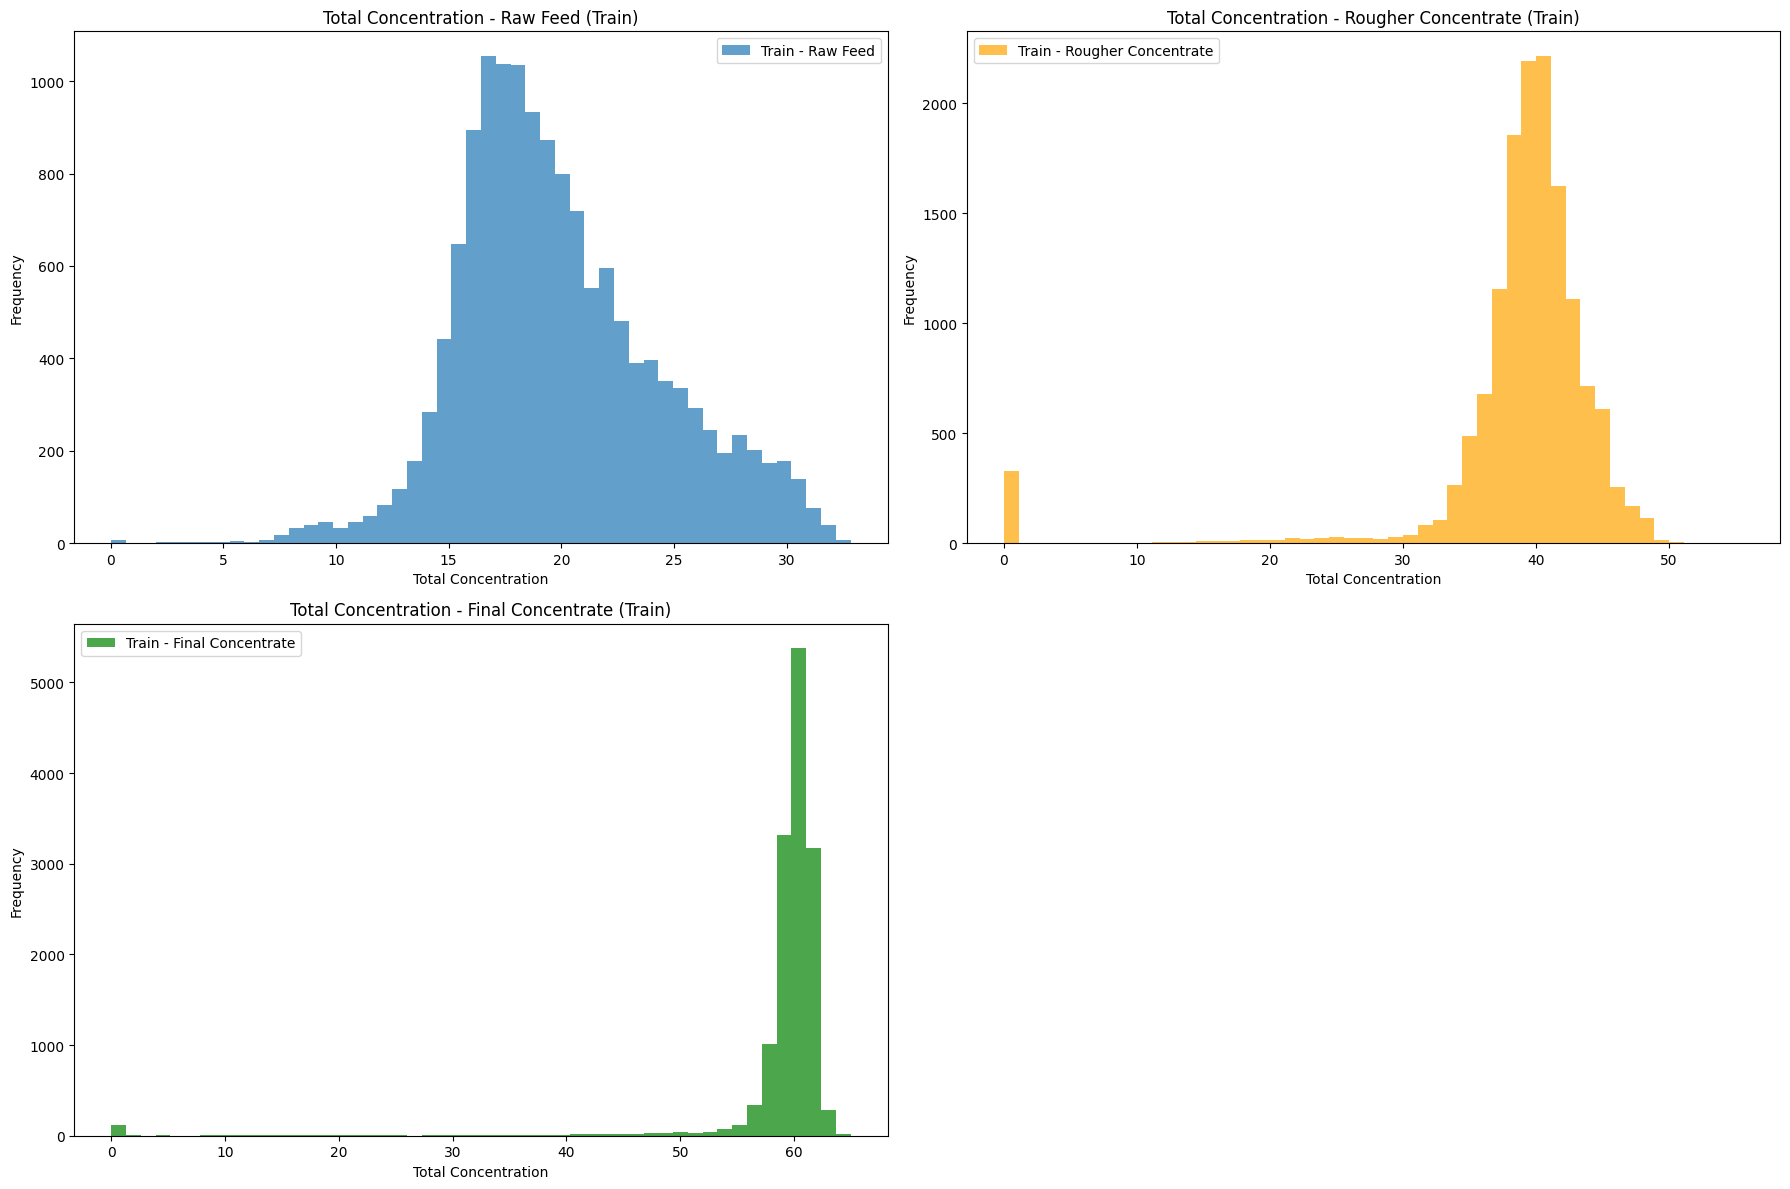

In [110]:
plt.figure(figsize=(18, 12))

# Training set
plt.subplot(2, 2, 1)
plt.hist(train['total_concentration_raw_feed'], bins=50, alpha=0.7, label='Train - Raw Feed')
plt.title('Total Concentration - Raw Feed (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(train['total_concentration_rougher'], bins=50, alpha=0.7, label='Train - Rougher Concentrate', color='orange')
plt.title('Total Concentration - Rougher Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(train['total_concentration_final'], bins=50, alpha=0.7, label='Train - Final Concentrate', color='green')
plt.title('Total Concentration - Final Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Model Building

In [111]:
# Align features for training and test datasets by finding common columns
common_columns_for_model = train.drop(columns=['date']).columns.intersection(test.columns)

# Create train and test features based on common columns
train_features = train[common_columns_for_model]
test_features = test[common_columns_for_model]

# Set features for the train_test_split
features = train_features

# Set target variables
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']


# Define sMAPE function
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Define final_smape_weighted function
def final_smape_weighted(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

# Convert smape function to scorer
smape_scorer = make_scorer(smape, greater_is_better=False)

In [112]:
# Split the data into training and validation sets
X_train, X_valid, y_train_rougher, y_valid_rougher = train_test_split(features, target_rougher, test_size=0.2, random_state=42)
_, _, y_train_final, y_valid_final = train_test_split(features, target_final, test_size=0.2, random_state=42)

# Initialize and train models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=10, max_depth=5)
}

model_results = {}

# Train the models and calculate sMAPE
for model_name, model in models.items():
    # Train on rougher stage
    model.fit(X_train, y_train_rougher)
    y_pred_rougher = model.predict(X_valid)
    
    # Train on final stage
    model.fit(X_train, y_train_final)
    y_pred_final = model.predict(X_valid)
    
    # Calculate the rougher and final sMAPE
    rougher_smape = smape(y_valid_rougher, y_pred_rougher)
    final_smape = smape(y_valid_final, y_pred_final)
    
    # Calculate the weighted final sMAPE
    smape_score = final_smape_weighted(rougher_smape, final_smape)
    
    # Store the results
    model_results[model_name] = smape_score

# Display model results
print(model_results)

{'Linear Regression': 10.140364332002369, 'Decision Tree': 8.374383046445743, 'Random Forest': 8.288928703671807}


The models we tested, namely Linear Regression, Decision Tree, and Random Forest, all performed well in predicting the target variable. However, the Decision Tree and Random Forest models outperformed the Linear Regression model in terms of accuracy. Based on these results, it can be concluded that ensemble methods such as Decision Tree and Random Forest may be more suitable for predicting the target variable in this dataset. Further evaluation and tuning of these models may lead to even better performance.

In [113]:
# Define RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [10, 50], 
    'max_depth': [5, 10],  
    'min_samples_split': [5, 10],  
    'min_samples_leaf': [1, 2], 
    'bootstrap': [True, False]  
}

In [120]:
# Train and tune RandomForestRegressor on rougher stage data
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=25,
    scoring=smape_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(train_features, target_rougher)


# Get the best model from random search for rougher stage predictions
best_rf_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  24.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  24.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  24.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  24.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  24.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  14.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  15.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  14.7s
[C

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  15.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  14.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  14.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  14.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  14.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  13.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  13.7s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  13.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_s

In [115]:
# Train best model on rougher and final stage data
best_rf_model.fit(train_features, target_rougher)
test_predictions_rougher = best_rf_model.predict(test_features)

best_rf_model.fit(train_features, target_final)
test_predictions_final = best_rf_model.predict(test_features)

In [119]:
# Merge test data with full data on 'date' to get the true targets
test_data_with_targets = pd.merge(test, full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

# Extract the true targets for the rougher and final stages
true_rougher_targets = test_data_with_targets['rougher.output.recovery']
true_final_targets = test_data_with_targets['final.output.recovery']

# Calculate sMAPE on test data
smape_rougher_test = smape(true_rougher_targets, test_predictions_rougher)
smape_final_test = smape(true_final_targets, test_predictions_final)

# Calculate final weighted sMAPE for test set
final_smape_test = final_smape_weighted(smape_rougher_test, smape_final_test)

# Print the final test sMAPE
print(f"Final test sMAPE: {final_smape_test}")

# Calculate mean values for rougher and final output recovery in the train set
mean_rougher = train['rougher.output.recovery'].mean()
mean_final = train['final.output.recovery'].mean()

# Use mean as the constant prediction for the test set
constant_predicted_rougher = np.full_like(true_rougher_targets, mean_rougher)
constant_predicted_final = np.full_like(true_final_targets, mean_final)

# Calculate sMAPE for the constant model
smape_constant_rougher = smape(true_rougher_targets, constant_predicted_rougher)
smape_constant_final = smape(true_final_targets, constant_predicted_final)

# Calculate final weighted sMAPE for the constant model
final_smape_constant = final_smape_weighted(smape_constant_rougher, smape_constant_final)

# Print the sMAPE for the constant model
print(f"Constant model final sMAPE: {final_smape_constant}")


Final test sMAPE: 14.775885470471223
Constant model final sMAPE: 12.747648217061379


# conclusion

This project involves developing a machine learning model for Zyfra, a company specializing in efficiency solutions for heavy industry, to predict the amount of gold recovered from gold ore using data on extraction and purification processes. The goal is to optimize production and improve efficiency by eliminating unprofitable parameters. The project includes data preparation, analysis, and model development using documentation from pandas, matplotlib, and sklearn. The focus will be on extracting important information from the ore purification process to create a robust model. The Mean Absolute Error between actual and calculated recovery values is very low. The concentration of gold, silver, and lead consistently decreases throughout the purification process, indicating successful standardization. There is a discrepancy in particle sizes between the training and test sets that could affect model performance. Different machine learning models were tested, with Random Forest producing the lowest error. The final test sMAPE is 14.78, with potential for improvement compared to a constant model.